In [44]:
import numpy as np
import gym
from gym.wrappers import Monitor
#For using environments of atari games
import tensorflow as tf
#For building CNNs
from PIL import Image
#For some image processing
import random
import copy
import os
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32

# Breakout

In [3]:
env = gym.envs.make("Breakout-v0")

[2017-11-10 00:07:50,084] Making new env: Breakout-v0


In [63]:
#testing the environment by choosing random actions
for i in range(2):
    state = env.reset()
    for t in range(500):
        env.render()
        action = env.action_space.sample()
        state,reward,done,_ = env.step(action)
        if done:
            break

In [136]:
def preprocess(state,show = False):
    if len(state.shape) == 4:
        state = state[0]
    img = Image.fromarray(state.astype('uint8'), 'RGB')
    img = img.convert('LA')
    img = img.crop((0,34,160,192))
    img = img.resize((84,84))
    img = np.array(img,np.float32)
    img = img[:,:,0]
    if show:
        plt.imshow(img)
        plt.show()
    img = np.stack([img] * 4, axis=2)
    return img

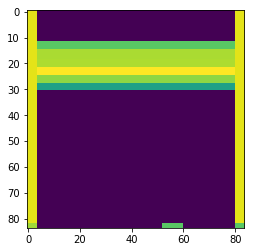

array([[[ 142.,  142.,  142.,  142.],
        [ 142.,  142.,  142.,  142.],
        [ 142.,  142.,  142.,  142.],
        ..., 
        [ 142.,  142.,  142.,  142.],
        [ 142.,  142.,  142.,  142.],
        [ 142.,  142.,  142.,  142.]],

       [[ 142.,  142.,  142.,  142.],
        [ 142.,  142.,  142.,  142.],
        [ 142.,  142.,  142.,  142.],
        ..., 
        [ 142.,  142.,  142.,  142.],
        [ 142.,  142.,  142.,  142.],
        [ 142.,  142.,  142.,  142.]],

       [[ 142.,  142.,  142.,  142.],
        [ 142.,  142.,  142.,  142.],
        [ 142.,  142.,  142.,  142.],
        ..., 
        [ 142.,  142.,  142.,  142.],
        [ 142.,  142.,  142.,  142.],
        [ 142.,  142.,  142.,  142.]],

       ..., 
       [[ 142.,  142.,  142.,  142.],
        [ 142.,  142.,  142.,  142.],
        [ 142.,  142.,  142.,  142.],
        ..., 
        [ 142.,  142.,  142.,  142.],
        [ 142.,  142.,  142.,  142.],
        [ 142.,  142.,  142.,  142.]],

       [[ 1

In [138]:
state = env.reset()

preprocess(state,True)

In [133]:
class DQN():
    def __init__(self,batch_size,scope):
        self.batch_size = batch_size
        self.scope = scope
        self.layers = {}
        self.model()
    
    def model(self):
        #tf.reset_default_graph()
        with tf.variable_scope(self.scope):
            #Placeholders for input(state), output(Value function) and actions
            self.input = tf.placeholder(tf.float32,shape=[None,84,84,4])
            self.output = tf.placeholder(tf.float32,shape=[None])
            self.actions = tf.placeholder(tf.int32,shape = [None])
            
            #Convolutional Layers
            
            initializer = tf.contrib.layers.xavier_initializer()
            self.layers['a1'] = tf.layers.conv2d(self.input,filters = 32,kernel_size=8,strides=4,
                                                 padding = 'SAME',kernel_initializer = initializer,name='conv1')
            self.layers['a1'] = tf.nn.relu(self.layers['a1'],name='relu1')
            self.layers['a2'] = tf.layers.conv2d(self.layers['a1'], filters= 64, kernel_size = 4, strides = 2,
                                                 padding = 'SAME', kernel_initializer = initializer,name='conv2')
            self.layers['a2'] = tf.nn.relu(self.layers['a2'],name='relu2')
            self.layers['a3'] = tf.layers.conv2d(self.layers['a2'],filters=64,kernel_size=3, strides=1,
                                                 padding = 'SAME',kernel_initializer = initializer, name='conv3')
            self.layers['a3'] = tf.nn.relu(self.layers['a3'],name='relu3')
            
            #Fully connected Layers
            shape = self.layers['a3'].get_shape().as_list()
            dims = shape[1]*shape[2]*shape[3]
            self.layers['a3'] = tf.reshape(self.layers['a3'],shape=[-1,dims],name='flat')
            self.layers['a4'] = tf.layers.dense(self.layers['a3'],512,kernel_initializer = initializer,name='fc1')
            self.layers['a4'] = tf.nn.relu(self.layers['a4'],name='relu4')
            self.layers['output'] = tf.layers.dense(self.layers['a4'],4,kernel_initializer = initializer,name='output')
            
            #Selecting values corresponding to the actions
            #inds = tf.concat([tf.reshape(tf.range(self.batch_size),[1,self.batch_size]),tf.reshape(self.actions,[1,self.batch_size])],axis=0)
            #inds = tf.transpose(inds)
            #self.value_funcs = tf.gather_nd(self.layers['output'],inds)
            
            inds = tf.range(self.batch_size) * tf.shape(self.layers['output'])[1] + self.actions
            self.value_funcs = tf.gather(tf.reshape(self.layers['output'], [-1]), inds)

            
            #Finding the loss
            self.loss = tf.reduce_mean((self.output - self.value_funcs)**2)
            
            #Global Step
            self.global_step = tf.Variable(0, name='global_step', trainable=False)
            
            #Optimizer
            self.opti = tf.train.RMSPropOptimizer(learning_rate=0.00025,momentum=0.95,decay=0.95,epsilon=1e-8).minimize(self.loss,self.global_step)
            
            
        

In [17]:
def copy_cnn_params(cnn1,cnn2):
    params_cnn1 = []
    params_cnn2 = []
    for var in tf.trainable_variables():
        if var.name.startswith(cnn1.scope):
            params_cnn1.append(var)
        elif var.name.startswith(cnn2.scope):
            params_cnn2.append(var)
    copy_op = []
    for i in range(len(params_cnn1)):
        copy_op.append(params_cnn2[i].assign(params_cnn1[i]))
    
    return copy_op
    
    
    

In [10]:
e1_params = [t for t in tf.trainable_variables() if t.name.startswith(q.scope)]

In [11]:
e1_params

[]

In [12]:
tf.reset_default_graph()
q1 = DQN(32,'tes1')
q2 =  DQN(32,'tes2')
copy_op = copy_cnn_params(q1,q2)

C:\Users\kabir\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[<tf.Variable 'tes1/conv1/kernel:0' shape=(8, 8, 4, 32) dtype=float32_ref>
 <tf.Variable 'tes1/conv1/bias:0' shape=(32,) dtype=float32_ref>
 <tf.Variable 'tes1/conv2/kernel:0' shape=(4, 4, 32, 64) dtype=float32_ref>
 <tf.Variable 'tes1/conv2/bias:0' shape=(64,) dtype=float32_ref>
 <tf.Variable 'tes1/conv3/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>
 <tf.Variable 'tes1/conv3/bias:0' shape=(64,) dtype=float32_ref>
 <tf.Variable 'tes1/fc1/kernel:0' shape=(7744, 512) dtype=float32_ref>
 <tf.Variable 'tes1/fc1/bias:0' shape=(512,) dtype=float32_ref>
 <tf.Variable 'tes1/output/kernel:0' shape=(512, 4) dtype=float32_ref>
 <tf.Variable 'tes1/output/bias:0' shape=(4,) dtype=float32_ref>]
[<tf.Variable 'tes2/conv1/kernel:0' shape=(8, 8, 4, 32) dtype=float32_ref>
 <tf.Variable 'tes2/conv1/bias:0' shape=(32,) dtype=float32_ref>
 <tf.Variable 'tes2/conv2/kernel:0' shape=(4, 4, 32, 64) dtype=float32_ref>
 <tf.Variable 'tes2/conv2/bias:0' shape=(64,) dtype=float32_ref>
 <tf.Variable 'tes2/conv3

In [13]:
copy_op

[<tf.Tensor 'Assign:0' shape=(8, 8, 4, 32) dtype=float32_ref>,
 <tf.Tensor 'Assign_1:0' shape=(32,) dtype=float32_ref>,
 <tf.Tensor 'Assign_2:0' shape=(4, 4, 32, 64) dtype=float32_ref>,
 <tf.Tensor 'Assign_3:0' shape=(64,) dtype=float32_ref>,
 <tf.Tensor 'Assign_4:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 <tf.Tensor 'Assign_5:0' shape=(64,) dtype=float32_ref>,
 <tf.Tensor 'Assign_6:0' shape=(7744, 512) dtype=float32_ref>,
 <tf.Tensor 'Assign_7:0' shape=(512,) dtype=float32_ref>,
 <tf.Tensor 'Assign_8:0' shape=(512, 4) dtype=float32_ref>,
 <tf.Tensor 'Assign_9:0' shape=(4,) dtype=float32_ref>]

In [13]:
def policy_func(state,sess,epsilon,num_actions,action_cnn):
    state = state[np.newaxis,:]
    preds = sess.run(action_cnn.layers['output'],{action_cnn.input:state})
    p = np.ones(num_actions)*epsilon/num_actions
    greedy_action = np.argmax(preds)
    p[greedy_action] += 1 - epsilon
    return p
    
    

In [11]:
def DQL(env,env1,sess,action_cnn,target_cnn,num_episodes,epsilons,discount_factor,replay_mem_size,batch_size,C,record,decay_rate):
    decay_count = tf.train.global_step(sess,action_cnn.global_step)
    print(decay_count)
    #Initializing Replay memory
    D = []
    state = env.reset()
    print("populating replay memory")
    for i in range(replay_mem_size//10):
        state = preprocess(state)
        action_probs = policy_func(state,sess,epsilons[min(decay_count,decay_rate-1)],4,action_cnn)
        action = np.random.choice(np.arange(len(action_probs)), p = action_probs)
        new_state,reward,done,_ = env.step(action)
        D.append((preprocess(state),action,reward,preprocess(new_state),done))
        if done:
            state = env.reset()
        else:
            state = new_state
            
    print("Been There Done That")
    saver = tf.train.Saver()
    # Load a previous checkpoint if we find one
    ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/'))
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
    
    #env = Monitor(env, directory='videos', video_callable=lambda count: count % record == 0, resume=True)
    losses = []        
    for i in range(num_episodes):
        saver.save(sess, 'checkpoints/DQN')
        state = env.reset()
        done = False
        decay_count = tf.train.global_step(sess,action_cnn.global_step)
        print("episode: ",i,"global_step: ",decay_count)
        ep_reward = 0
        while done == False:
            state = preprocess(state)
            action_probs = policy_func(state,sess,epsilons[min(decay_count,decay_rate-1)],4,action_cnn)
            action = np.random.choice(np.arange(len(action_probs)), p = action_probs)
            new_state,reward,done,_ = env.step(action)
            ep_reward += reward
            new_state = preprocess(new_state)
            if(len(D)==replay_mem_size):
                D.pop(0)
            D.append((state,action,reward,new_state,done))
            
            batch = random.sample(D,batch_size)
            states = []
            actions = []
            rewards = []
            new_states = []
            dones = []
            
            for a in batch:
                states.append(a[0])
                actions.append(a[1])
                rewards.append(a[2])
                new_states.append(a[3])
                dones.append(a[4])
            
            flags = np.invert(dones)
            y = rewards + flags*discount_factor*np.max(sess.run(target_cnn.layers['output'],
                                                                {target_cnn.input:new_states}),axis=1)
            loss,_ = sess.run([action_cnn.loss,action_cnn.opti],{action_cnn.input:states,action_cnn.output:y,
                                                                 action_cnn.actions:actions})
            losses.append(loss)
            if decay_count%C == 0:
                print(loss)
                copy_op = copy_cnn_params(action_cnn,target_cnn)
                sess.run(copy_op)
        
            new_state = state
        print("Reward: ",ep_reward)
        

In [12]:
np.invert([True,False])*[1,2]

array([0, 2])

In [13]:
tf.reset_default_graph()
action_cnn = DQN(BATCH_SIZE,'action_cnn')
target_cnn = DQN(BATCH_SIZE,'target_cnn')
decay_rate = 500000
epsilons = np.linspace(1,0.1,decay_rate)

/home/kabir/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [14]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    copy_op = copy_cnn_params(action_cnn,target_cnn)
    sess.run(copy_op)
    DQL(env,env1,sess,action_cnn,target_cnn,10000,epsilons,discount_factor=0.99,replay_mem_size=500000,
        batch_size=BATCH_SIZE,C=10000,record=50,decay_rate=decay_rate)
    

populating replay memory


KeyboardInterrupt: 

In [20]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    checkpoint = tf.train.latest_checkpoint('checkpoints/')
    print(checkpoint)
    if checkpoint:
        print("Loading model checkpoint {}...\n".format(checkpoint))
        saver.restore(sess, checkpoint)
    #ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/'))
    #if ckpt and ckpt.model_checkpoint_path:
    #    saver.restore(sess, ckpt.model_checkpoint_path)
        
    print("Playing")
    state = env1.reset()
    for t in range(50000):
        state = preprocess(state)
        env1.render()
        action_probs = policy_func(state,sess,epsilons[decay_rate-1],4,action_cnn)
        action = np.random.choice(np.arange(len(action_probs)), p = action_probs)
        state,reward,done,_ = env1.step(action)
        if done:
            print("Game Over")
            break
    print("Played")
    
    

checkpoints/DQN
Loading model checkpoint checkpoints/DQN...

INFO:tensorflow:Restoring parameters from checkpoints/DQN
Playing
Game Over
Played
